# Exercicio 2 - 🖼️ Classificação Imagens -> CIFAR-10

Considere uma rede deep learning convolutiva (treinada) aplicada à lassificação de padrões em imagens. A base de dados considerada é a CIFAR-10 (pesquise). A referida base de dados consiste de 60 mil imagens coloridas de 32x32 pixels, com 50 mil para treino e 10 mil para teste. As imagens estão divididas em 10 classes, a saber: avião, navio, caminhão, automóvel, sapo, pássaro, cachorro, gato, cavalo e cervo. Cada imagem possui apenas um dos objetos da classe de interesse, podendo estar parcialmente obstruído por outros objetos que não pertençam a esse conjunto. Apresente o desempenho da rede no processo de classificação usando uma matriz de confusão.

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Load the CIFAR-10 dataset

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [16]:
# verify the shape
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


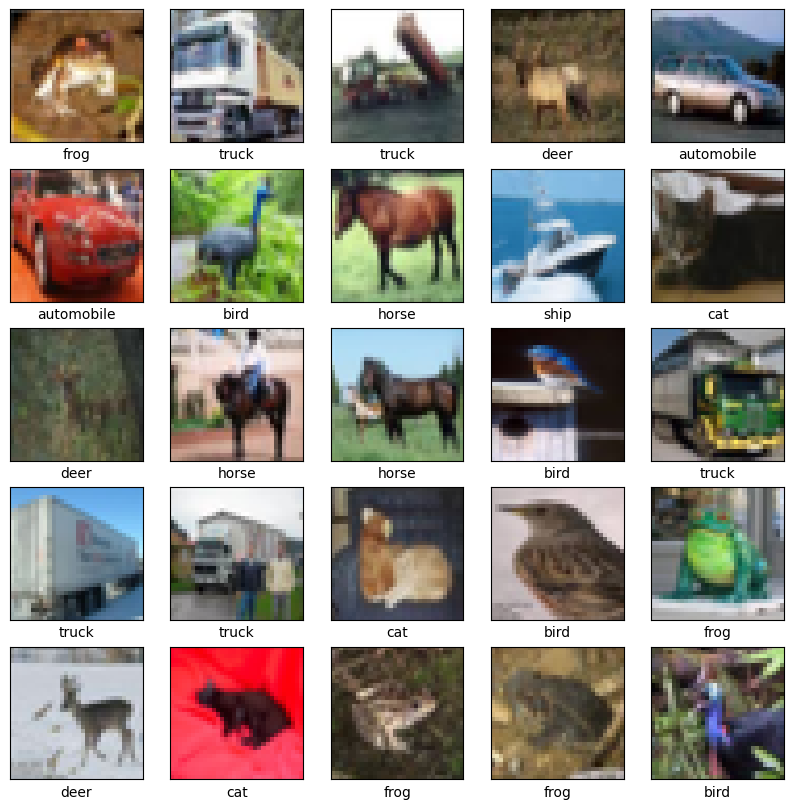

In [17]:
# transformando em strings a numeração da classe
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [18]:
x_train.dtype

dtype('uint8')

In [19]:
x_test.dtype

dtype('uint8')

## Raw Model

### Preprocess the data

In [20]:
#transform data in float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [21]:
# Normalization Data.
# By dividing by 255.0, you are scaling these pixel values to be between 0 and 1.
x_train /= 255.0
x_test /= 255.0

In [22]:
#transform y variable in categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Define the model architecture

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

### Compile the model

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

###  Callbacks

In [26]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Train the model

In [27]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3541 - loss: 2.0285

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.3542 - loss: 2.0280 - val_accuracy: 0.5803 - val_loss: 1.1975
Epoch 2/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5967 - loss: 1.1385

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5968 - loss: 1.1383 - val_accuracy: 0.6916 - val_loss: 0.8819
Epoch 3/50
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6863 - loss: 0.8955

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6863 - loss: 0.8953 - val_accuracy: 0.7389 - val_loss: 0.7435
Epoch 4/50
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7339 - loss: 0.7766

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7339 - loss: 0.7765 - val_accuracy: 0.7409 - val_loss: 0.7851
Epoch 5/50
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7515 - loss: 0.7125

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7515 - loss: 0.7125 - val_accuracy: 0.7512 - val_loss: 0.7089
Epoch 6/50
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7782 - loss: 0.6470

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7782 - loss: 0.6470 - val_accuracy: 0.7729 - val_loss: 0.6496
Epoch 7/50
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7979 - loss: 0.5905

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7978 - loss: 0.5906 - val_accuracy: 0.7922 - val_loss: 0.6218
Epoch 8/50
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8061 - loss: 0.5613

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8061 - loss: 0.5613 - val_accuracy: 0.8039 - val_loss: 0.5785
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8261 - loss: 0.5187 - val_accuracy: 0.7878 - val_loss: 0.6288
Epoch 10/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8314 - loss: 0.4913

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8314 - loss: 0.4913 - val_accuracy: 0.8166 - val_loss: 0.5327
Epoch 11/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8382 - loss: 0.4712 - val_accuracy: 0.8123 - val_loss: 0.5694
Epoch 12/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8482 - loss: 0.4411

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8482 - loss: 0.4412 - val_accuracy: 0.8356 - val_loss: 0.5037
Epoch 13/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8549 - loss: 0.4222 - val_accuracy: 0.8198 - val_loss: 0.5409
Epoch 14/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8610 - loss: 0.4041 - val_accuracy: 0.8070 - val_loss: 0.5904
Epoch 15/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8663 - loss: 0.3922 - val_accuracy: 0.8249 - val_loss: 0.5346
Epoch 16/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8728 - loss: 0.3754 - val_accuracy: 0.8298 - val_loss: 0.5178
Epoch 17/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8766 - loss: 0.3609 - val_accuracy: 0.8053 - val_loss: 0.6058
Epoch 18/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8805 - loss: 0.3430

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8805 - loss: 0.3431 - val_accuracy: 0.8422 - val_loss: 0.4688
Epoch 19/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8836 - loss: 0.3401

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8835 - loss: 0.3401 - val_accuracy: 0.8476 - val_loss: 0.4700
Epoch 20/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8884 - loss: 0.3261 - val_accuracy: 0.8404 - val_loss: 0.5064
Epoch 21/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8897 - loss: 0.3242

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8897 - loss: 0.3242 - val_accuracy: 0.8479 - val_loss: 0.4797
Epoch 22/50
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8941 - loss: 0.3047

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8941 - loss: 0.3048 - val_accuracy: 0.8531 - val_loss: 0.4712
Epoch 23/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8926 - loss: 0.3082 - val_accuracy: 0.8527 - val_loss: 0.4768
Epoch 24/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9011 - loss: 0.2875 - val_accuracy: 0.8504 - val_loss: 0.4701
Epoch 25/50
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8998 - loss: 0.2833

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8998 - loss: 0.2834 - val_accuracy: 0.8544 - val_loss: 0.4723
Epoch 26/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8993 - loss: 0.2875

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8993 - loss: 0.2875 - val_accuracy: 0.8580 - val_loss: 0.4613
Epoch 27/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9037 - loss: 0.2743 - val_accuracy: 0.8548 - val_loss: 0.4648
Epoch 28/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9067 - loss: 0.2724 - val_accuracy: 0.8579 - val_loss: 0.4556
Epoch 29/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9069 - loss: 0.2626 - val_accuracy: 0.8482 - val_loss: 0.4934
Epoch 30/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9092 - loss: 0.2586 - val_accuracy: 0.8575 - val_loss: 0.4787
Epoch 31/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9117 - loss: 0.2555 - val_accuracy: 0.8540 - val_loss: 0.4764
Epoch 32/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9130 - loss: 0.2490 - val_accuracy: 0.8546 - val_loss: 0.5066
Epoch 33/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9154 - loss: 0.2452 - val_accuracy: 0.85

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9177 - loss: 0.2369 - val_accuracy: 0.8618 - val_loss: 0.4588
Epoch 35/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9196 - loss: 0.2331 - val_accuracy: 0.8618 - val_loss: 0.4671
Epoch 36/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9217 - loss: 0.2241 - val_accuracy: 0.8506 - val_loss: 0.5150
Epoch 37/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9212 - loss: 0.2252

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9212 - loss: 0.2252 - val_accuracy: 0.8675 - val_loss: 0.4469
Epoch 38/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9228 - loss: 0.2255 - val_accuracy: 0.8608 - val_loss: 0.4664
Epoch 39/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9215 - loss: 0.2193 - val_accuracy: 0.8675 - val_loss: 0.4558
Epoch 40/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9258 - loss: 0.2105 - val_accuracy: 0.8620 - val_loss: 0.4765
Epoch 41/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9264 - loss: 0.2092 - val_accuracy: 0.8613 - val_loss: 0.4713
Epoch 42/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9243 - loss: 0.2171 - val_accuracy: 0.8632 - val_loss: 0.4799
Epoch 43/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9304 - loss: 0.2038 - val_accuracy: 0.8579 - val_loss: 0.4915
Epoch 44/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9303 - loss: 0.1990 - val_accuracy: 0

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9291 - loss: 0.2062 - val_accuracy: 0.8683 - val_loss: 0.4519
Epoch 46/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9322 - loss: 0.1942 - val_accuracy: 0.8654 - val_loss: 0.4751
Epoch 47/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9332 - loss: 0.1926 - val_accuracy: 0.8654 - val_loss: 0.4632


### Evaluate the model on the test set

In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - 5ms/step - accuracy: 0.8675 - loss: 0.4469

Test accuracy: 0.8675000071525574


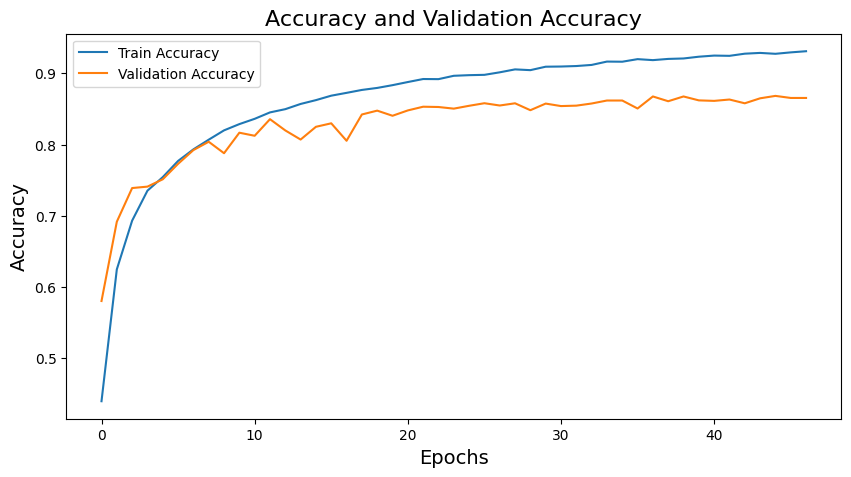

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy and Validation Accuracy', fontsize=16)
plt.legend()
plt.show()

### Make predictions on the test set

In [30]:
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


### Convert predictions from one-hot encoding to class labels

In [31]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

### Create and Print the confusion matrix

In [33]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

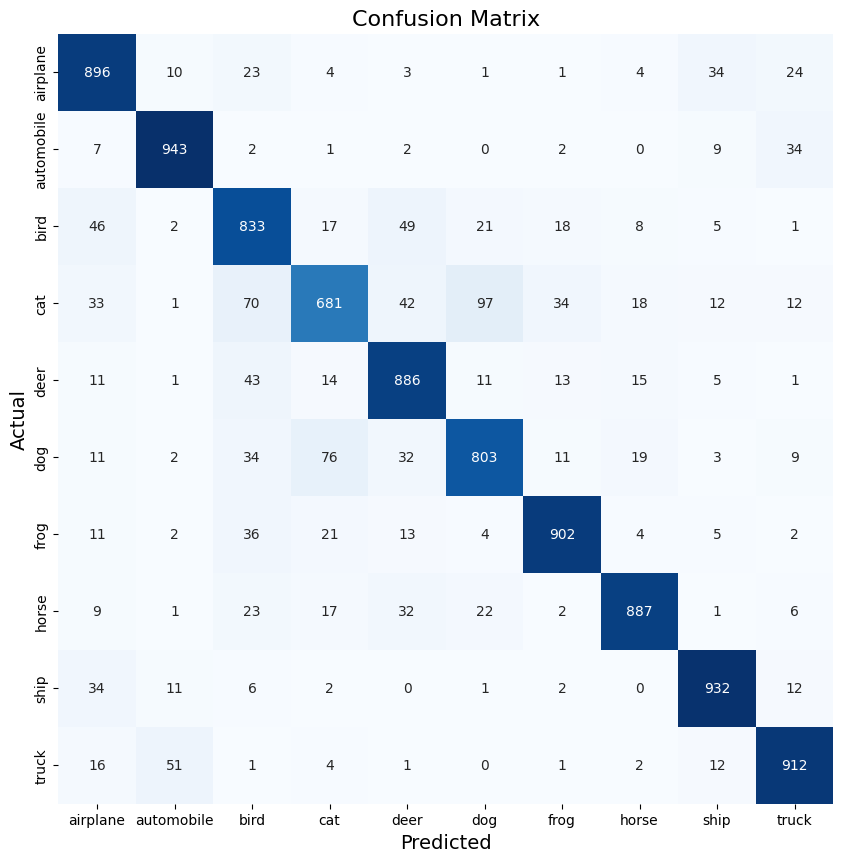

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Transfer Learning from DenseNet201

### Define the model architecture

In [37]:
# instantiate the model
vgg16 = VGG16(
      include_top=False,
      weights="imagenet",
      input_shape=(32, 32, 3),
)

vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Congela os pesos das camadas do modelo base
for layer in vgg16.layers:
    layer.trainable = False

# Adiciona as camadas personalizadas ao modelo
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

# Cria o novo modelo com as camadas personalizadas
model = Model(inputs=vgg16.input, outputs=output)

# Visualiza a arquitetura do modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,782,154 (56.39 MB)

 Trainable params: 67,210 (262.54 KB)

 Non-trainable params: 14,714,944 (56.13 MB)

### Compile the model

In [39]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Callbacks

In [40]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Train the model

In [41]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3891 - loss: 1.8381

782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.3892 - loss: 1.8378 - val_accuracy: 0.5517 - val_loss: 1.2807
Epoch 2/50
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5382 - loss: 1.3356

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5382 - loss: 1.3356 - val_accuracy: 0.5687 - val_loss: 1.2360
Epoch 3/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5546 - loss: 1.2890

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5547 - loss: 1.2890 - val_accuracy: 0.5761 - val_loss: 1.2090
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.5639 - loss: 1.2623 - val_accuracy: 0.5659 - val_loss: 1.2246
Epoch 5/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5717 - loss: 1.2429

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5717 - loss: 1.2429 - val_accuracy: 0.5845 - val_loss: 1.1935
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5724 - loss: 1.2350 - val_accuracy: 0.5783 - val_loss: 1.2037
Epoch 7/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5798 - loss: 1.2176

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5798 - loss: 1.2177 - val_accuracy: 0.5878 - val_loss: 1.1805
Epoch 8/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5798 - loss: 1.2201

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5798 - loss: 1.2201 - val_accuracy: 0.5881 - val_loss: 1.1827
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5849 - loss: 1.2093 - val_accuracy: 0.5792 - val_loss: 1.1938
Epoch 10/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5833 - loss: 1.2001 - val_accuracy: 0.5869 - val_loss: 1.1795
Epoch 11/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5895 - loss: 1.1897 - val_accuracy: 0.5869 - val_loss: 1.1804
Epoch 12/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5912 - loss: 1.1831

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5912 - loss: 1.1831 - val_accuracy: 0.5936 - val_loss: 1.1698
Epoch 13/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5908 - loss: 1.1870 - val_accuracy: 0.5916 - val_loss: 1.1626
Epoch 14/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5945 - loss: 1.1757 - val_accuracy: 0.5906 - val_loss: 1.1719
Epoch 15/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5922 - loss: 1.1814 - val_accuracy: 0.5923 - val_loss: 1.1678
Epoch 16/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5936 - loss: 1.1778 - val_accuracy: 0.5935 - val_loss: 1.1692
Epoch 17/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5954 - loss: 1.1721

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5954 - loss: 1.1722 - val_accuracy: 0.5982 - val_loss: 1.1519
Epoch 18/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5962 - loss: 1.1680 - val_accuracy: 0.5969 - val_loss: 1.1556
Epoch 19/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5923 - loss: 1.1735 - val_accuracy: 0.5864 - val_loss: 1.1764
Epoch 20/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5966 - loss: 1.1687 - val_accuracy: 0.5973 - val_loss: 1.1484
Epoch 21/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6014 - loss: 1.1574

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6013 - loss: 1.1574 - val_accuracy: 0.5997 - val_loss: 1.1532
Epoch 22/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5989 - loss: 1.1643 - val_accuracy: 0.5950 - val_loss: 1.1507
Epoch 23/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5988 - loss: 1.1586 - val_accuracy: 0.5982 - val_loss: 1.1511
Epoch 24/50
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6046 - loss: 1.1473

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6045 - loss: 1.1473 - val_accuracy: 0.6005 - val_loss: 1.1463
Epoch 25/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6063 - loss: 1.1454 - val_accuracy: 0.5953 - val_loss: 1.1533
Epoch 26/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6060 - loss: 1.1422 - val_accuracy: 0.5937 - val_loss: 1.1505
Epoch 27/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6052 - loss: 1.1414 - val_accuracy: 0.6005 - val_loss: 1.1417
Epoch 28/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6046 - loss: 1.1431 - val_accuracy: 0.5970 - val_loss: 1.1435
Epoch 29/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6078 - loss: 1.1303 - val_accuracy: 0.5981 - val_loss: 1.1493
Epoch 30/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6063 - loss: 1.1416 - val_accuracy: 0.6000 - val_loss: 1.1471
Epoch 31/50
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6122 - loss: 1.1225

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6122 - loss: 1.1226 - val_accuracy: 0.6022 - val_loss: 1.1419
Epoch 32/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6088 - loss: 1.1238 - val_accuracy: 0.6007 - val_loss: 1.1424
Epoch 33/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6051 - loss: 1.1389 - val_accuracy: 0.5973 - val_loss: 1.1467
Epoch 34/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6071 - loss: 1.1277 - val_accuracy: 0.5980 - val_loss: 1.1481
Epoch 35/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6088 - loss: 1.1285

782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6088 - loss: 1.1285 - val_accuracy: 0.6024 - val_loss: 1.1418
Epoch 36/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6078 - loss: 1.1269 - val_accuracy: 0.6005 - val_loss: 1.1438
Epoch 37/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6099 - loss: 1.1249 - val_accuracy: 0.6013 - val_loss: 1.1464


### Evaluate the model on test set

In [42]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 4s - 13ms/step - accuracy: 0.6005 - loss: 1.1417

Test accuracy: 0.6004999876022339


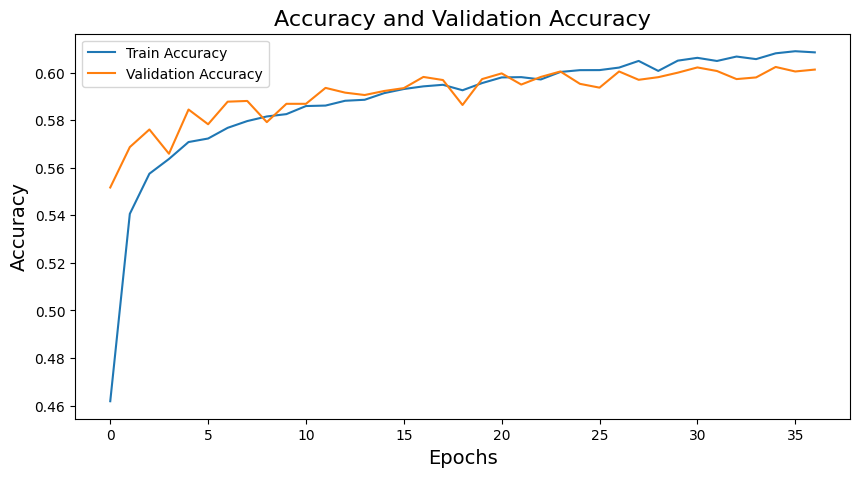

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy and Validation Accuracy', fontsize=16)
plt.legend()
plt.show()

### Make predictions on the test set

In [44]:
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


### Convert predictions from one-hot encoding to class labels

In [45]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

### Create and Print confusion matrix

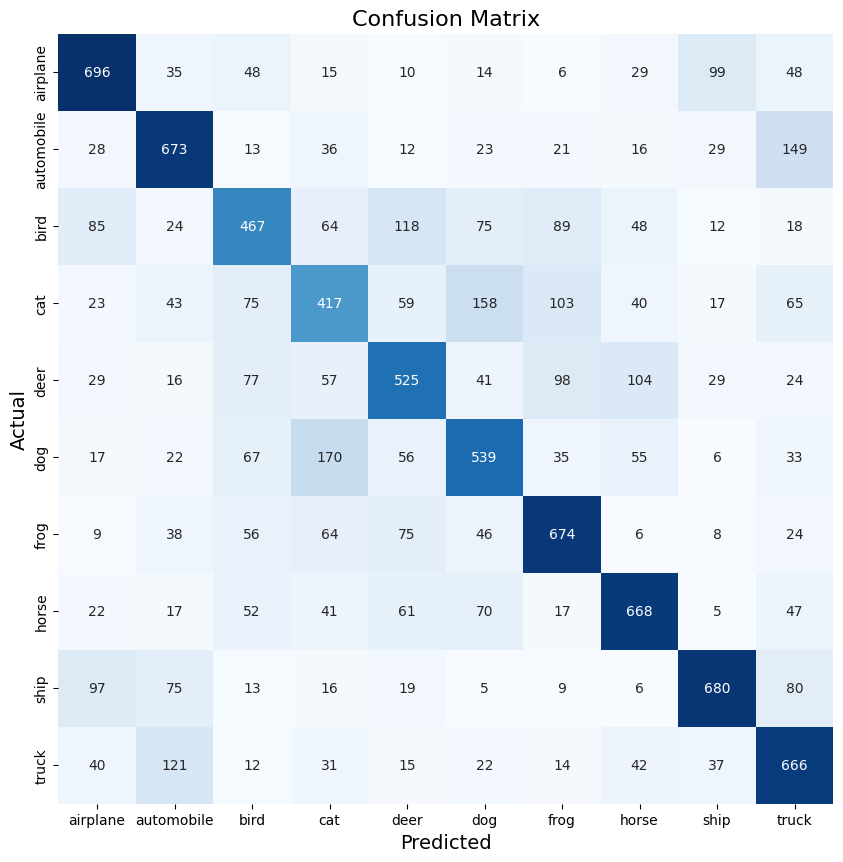

In [47]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

A análise dos resultados revela que o modelo que utilizou transfer learning com a rede VGG16 teve um desempenho inferior ao modelo treinado do zero. Foram observadas, por exemplo, confusões frequentes entre as classes "carro" e "avião", assim como entre "cachorro" e "gato", entre outras inconsistências. No entanto, embora este resultado específico indique limitações, é importante ressaltar que, de forma geral, a técnica de transfer learning tende a apresentar vantagens em relação aos modelos treinados do zero, sobretudo ao ser aplicada em diferentes contextos e conjuntos de dados.
